# Model Metrics

## How accurate is the model?

 - Compute Root Mean Square Error to determine bias in actual units
 - Normalize it to compare across models
 
## How representative is the model?

 - Compute Coefficient of Variation (CV) and compare to the observed CV
 - For which models can we **not** reject the hull hypothesis that the model data and observed data are samples from the statistical distribution?
   - Kolmogorov–Smirnov (KS) k-samples test (more sensitive to the centers of distributions)
   - Anderson-Darling (AD) test (more senstive to outliers)
   
<p>
The **null hypothesis** that the samples come from the same distribution. We would interpret a failure to reject his hypothesis as an indication of the model representing the observations.
    
    u can be rejected at the 5% level because the returned test value is greater than the critical value for 5% (1.961) but not at the 2.5% level. The interpolation gives an approximate significance level of 3.2%:
</p>

## How skillful is the model

 - Compare to a baseline forecast (e.g, the climatogical normal value is forecast for each value)
 - However, we would expect skill to increase w.r.t to a naive forecast over time.

In [4]:
import pandas as pd
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson_ksamp
from scipy.stats import ks_2samp

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

gcms = ["5ModelAvg", "GFDL-CM3", "GISS-E2-R", "IPSL-CM5A-LR", "MRI-CGCM3", "CCSM4"]
rcps = ["rcp45", "rcp60", "rcp85"]
clim_vars = ["pr_total_mm", "tas_mean_C"]

with open('extracted_data/ak_station_extractions.pickle', 'rb') as handle:
    di = pickle.load(handle)

In [5]:
def compute_cv(sample):
    cv = sample.mean() / sample.std()
    return round(cv, 2)


def nrmse(obs, predicted):
    # Calculate the RMSE
    rmse = np.sqrt(np.mean((predicted - obs) ** 2))

    # Calculate the range of the observed data
    data_range = max(observed) - min(obs)

    # Calculate the NRMSE
    nrmse = rmse / data_range

    return np.round(nrmse, 2), np.round(rmse, 2)

In [7]:
cv_vals = []
delta_cv_vals = []
nrmse_vals = []
rmse_vals = []
ad_vals = []
ks_vals = []

stations = []
stat_rcp = []
stat_gcm = []
stat_clim_vars = []

for station in di.keys():
    for model in gcms:
        for rcp in rcps:
            for var in clim_vars:
                modeled = di[station]["extracted_data"].loc[model].loc[rcp].loc[var]
                modeled = modeled.set_index(pd.DatetimeIndex(modeled.index.values))
                
                observed = di[station][var]
                assert len(observed) == 204
                
                stations.append(station)
                stat_rcp.append(rcp)
                stat_gcm.append(model)
                stat_clim_vars.append(var)
                
                cv_vals.append(compute_cv(modeled).value)
                delta_cv_vals.append(abs(compute_cv(observed) - compute_cv(modeled)).value)
                se_vals = nrmse(observed, modeled.value.values)
                nrmse_vals.append(se_vals[0])
                rmse_vals.append(se_vals[1])
                
                a, b, c = anderson_ksamp([modeled.value.values, observed])
                ad_vals.append([a, b, c])
                ks_vals.append(ks_2samp(modeled.value.values, observed, method="exact"))

In [8]:
statdf = pd.DataFrame(nrmse_vals)
statdf["Station"] = stations
statdf["Scenario"] = stat_rcp
statdf["Model"] = stat_gcm
statdf["Variable"] = stat_clim_vars

statdf["CV"] = cv_vals
statdf["NRMSE"] = nrmse_vals
statdf["RMSE"] = rmse_vals
statdf["CV Delta From Observed"] = delta_cv_vals

statdf["AD Null Hypothesis Rejection"] = [round(x[2], 2) for x in ad_vals]
statdf["KS p-value"] = [round(x[1], 2) for x in ks_vals]

del statdf[0]
statdf

,Station,Scenario,Model,Variable,CV,NRMSE,RMSE,CV Delta From Observed,AD Null Hypothesis Rejection,KS p-value
0,Juneau,rcp45,5ModelAvg,pr_total_mm,2.26,0.26,95.77,0.33,0.01,0.09
1,Juneau,rcp45,5ModelAvg,tas_mean_C,1.07,0.36,8.29,0.16,0.16,0.28
2,Juneau,rcp60,5ModelAvg,pr_total_mm,2.11,0.27,100.03,0.18,0.00,0.01
3,Juneau,rcp60,5ModelAvg,tas_mean_C,1.07,0.36,8.39,0.16,0.11,0.34
4,Juneau,rcp85,5ModelAvg,pr_total_mm,2.15,0.27,99.34,0.22,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...
319,Utqiaġvik,rcp45,CCSM4,tas_mean_C,-0.84,0.39,16.06,0.02,0.25,0.72
320,Utqiaġvik,rcp60,CCSM4,pr_total_mm,1.29,0.33,18.87,0.16,0.00,0.00
321,Utqiaġvik,rcp60,CCSM4,tas_mean_C,-0.81,0.39,16.30,0.01,0.25,0.64
322,Utqiaġvik,rcp85,CCSM4,pr_total_mm,1.28,0.33,19.04,0.15,0.00,0.00


In [9]:
# These are the models where, per the A-D test, we fail to reject the null hypothesis.
ad_reject_fail = statdf[statdf["AD Null Hypothesis Rejection"] > 0.05]
# These are the models where, per the KS test, we fail to reject the null hypothesis.
ks_reject_fail = statdf[statdf["KS p-value"] > 0.05]
# Fail to reject models for both KS and AD
ks_and_ad_reject_fail = ad_reject_fail.merge(ks_reject_fail)
ks_and_ad_reject_fail

,Station,Scenario,Model,Variable,CV,NRMSE,RMSE,CV Delta From Observed,AD Null Hypothesis Rejection,KS p-value
0,Juneau,rcp45,5ModelAvg,tas_mean_C,1.07,0.36,8.29,0.16,0.16,0.28
1,Juneau,rcp60,5ModelAvg,tas_mean_C,1.07,0.36,8.39,0.16,0.11,0.34
2,Juneau,rcp85,5ModelAvg,tas_mean_C,1.10,0.36,8.27,0.19,0.07,0.23
3,Juneau,rcp60,GFDL-CM3,tas_mean_C,1.00,0.37,8.62,0.09,0.14,0.34
4,Juneau,rcp85,GFDL-CM3,pr_total_mm,1.93,0.27,101.35,0.00,0.15,0.19
...,...,...,...,...,...,...,...,...,...,...
170,Utqiaġvik,rcp60,MRI-CGCM3,pr_total_mm,0.93,0.41,23.54,0.20,0.06,0.23
171,Utqiaġvik,rcp85,MRI-CGCM3,tas_mean_C,-0.95,0.39,16.14,0.13,0.11,0.23
172,Utqiaġvik,rcp45,CCSM4,tas_mean_C,-0.84,0.39,16.06,0.02,0.25,0.72
173,Utqiaġvik,rcp60,CCSM4,tas_mean_C,-0.81,0.39,16.30,0.01,0.25,0.64


In [12]:
# Split the fail-to-reject cases by variable
tasmax_perf = ks_and_ad_reject_fail[statdf["Variable"] == "tas_mean_C"]
pr_perf = ks_and_ad_reject_fail[statdf["Variable"] == "pr_total_mm"]

In [13]:
# Which models are representative for both variables?
tasmax_and_pr_perf = tasmax_perf[["Station", "Model", "Scenario"]].merge(pr_perf[["Station", "Model", "Scenario"]])
tasmax_and_pr_perf

,Station,Model,Scenario
0,Juneau,GISS-E2-R,rcp45
1,Juneau,GISS-E2-R,rcp60
2,Juneau,IPSL-CM5A-LR,rcp45
3,Juneau,MRI-CGCM3,rcp45
4,Juneau,MRI-CGCM3,rcp60
5,Juneau,MRI-CGCM3,rcp85
6,Juneau,CCSM4,rcp85
7,Ketchikan,GISS-E2-R,rcp60
8,Ketchikan,IPSL-CM5A-LR,rcp45
9,Ketchikan,IPSL-CM5A-LR,rcp60


In [12]:
tasmax_and_pr_perf.groupby(["Scenario", "Model"])["Station"].apply(list)

Scenario  Model       
rcp45     GFDL-CM3                                         [Juneau]
          GISS-E2-R                    [Ketchikan, Anchorage, Nome]
          IPSL-CM5A-LR                                  [Ketchikan]
          MRI-CGCM3       [Ketchikan, King Salmon, Anchorage, Nome]
          NCAR-CCSM4                      [Juneau, Ketchikan, Nome]
rcp85     GISS-E2-R            [Juneau, Ketchikan, Anchorage, Nome]
          IPSL-CM5A-LR                     [Ketchikan, King Salmon]
          MRI-CGCM3                                     [Ketchikan]
          NCAR-CCSM4                   [Ketchikan, Anchorage, Nome]
Name: Station, dtype: object

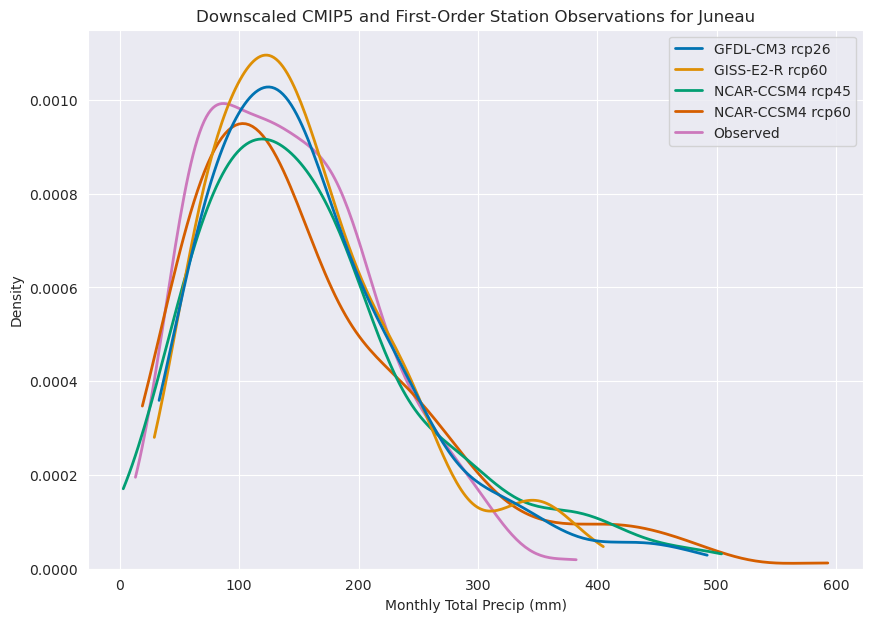

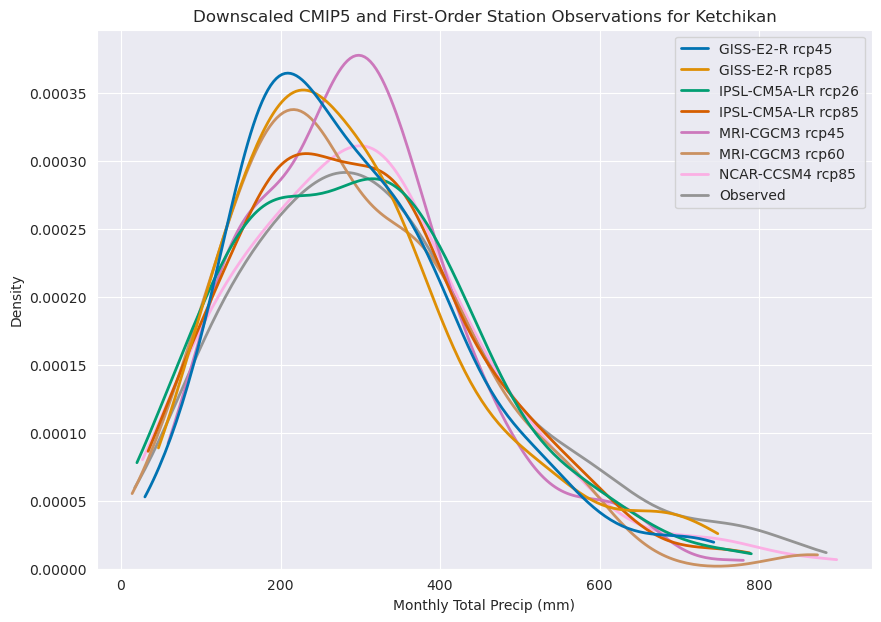

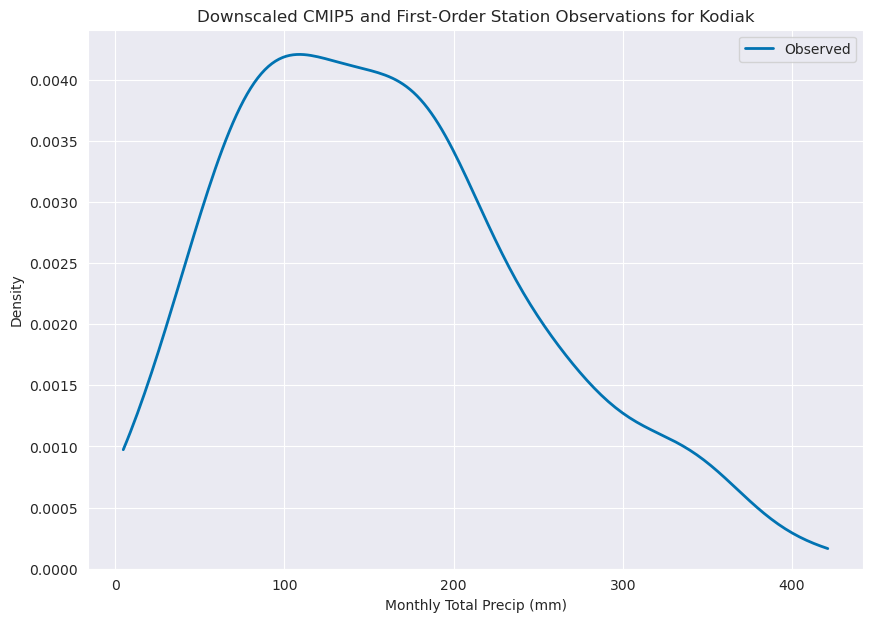

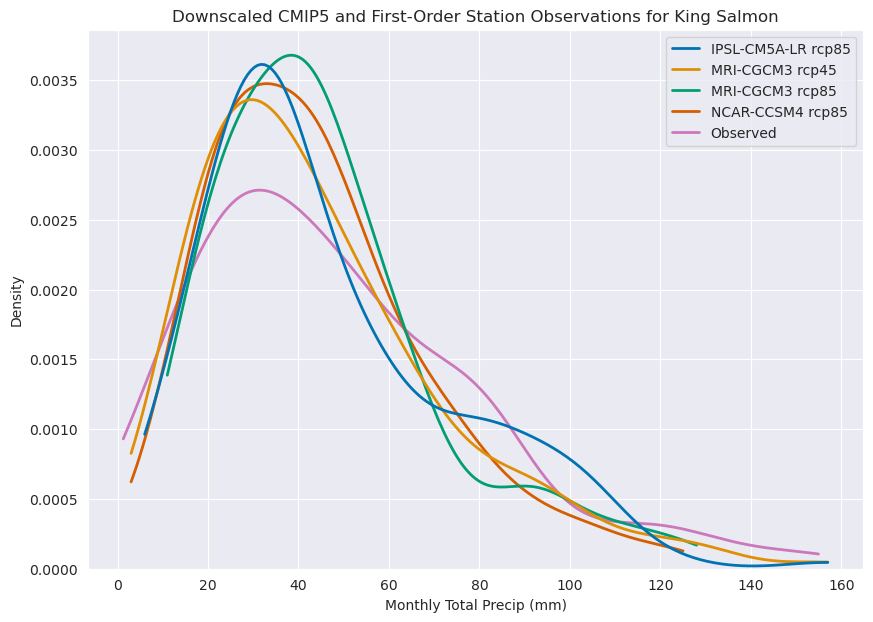

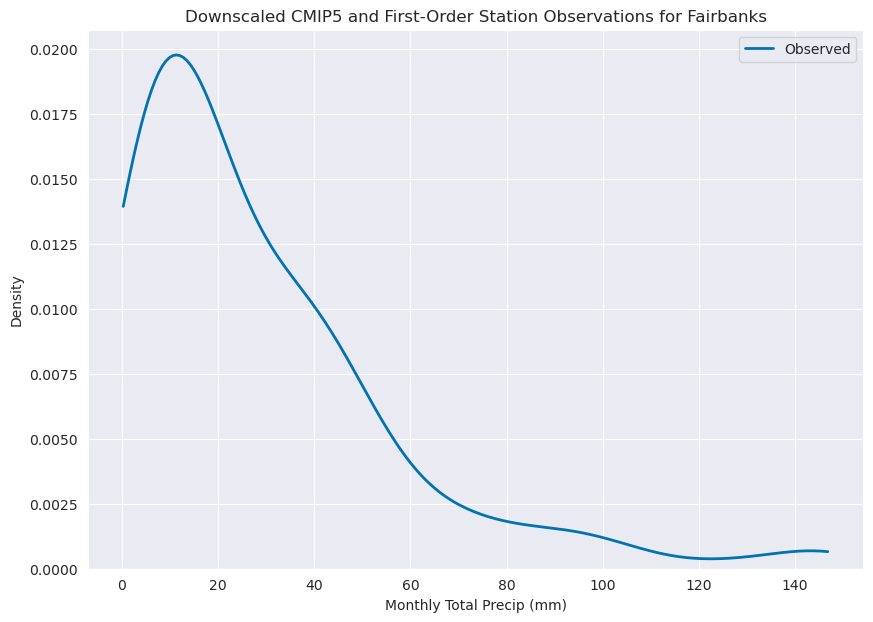

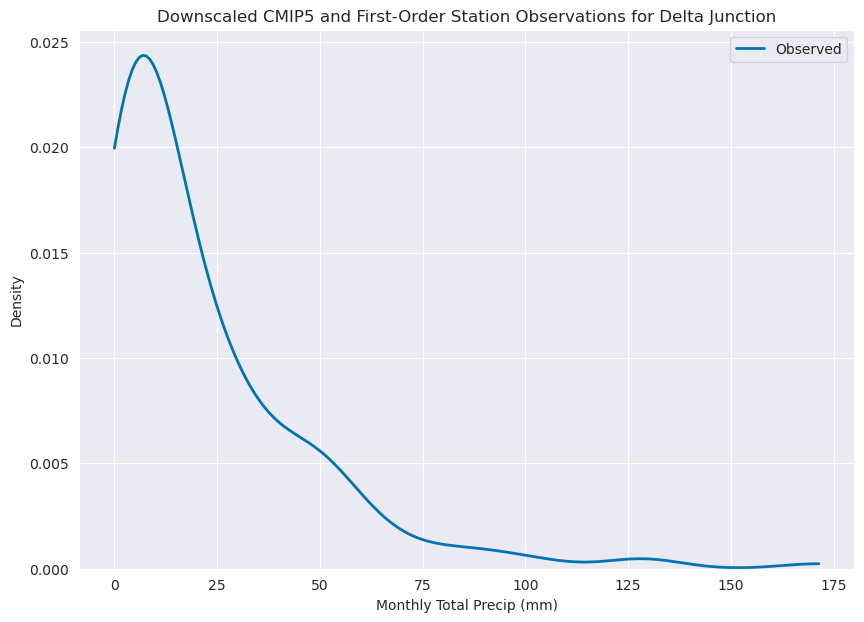

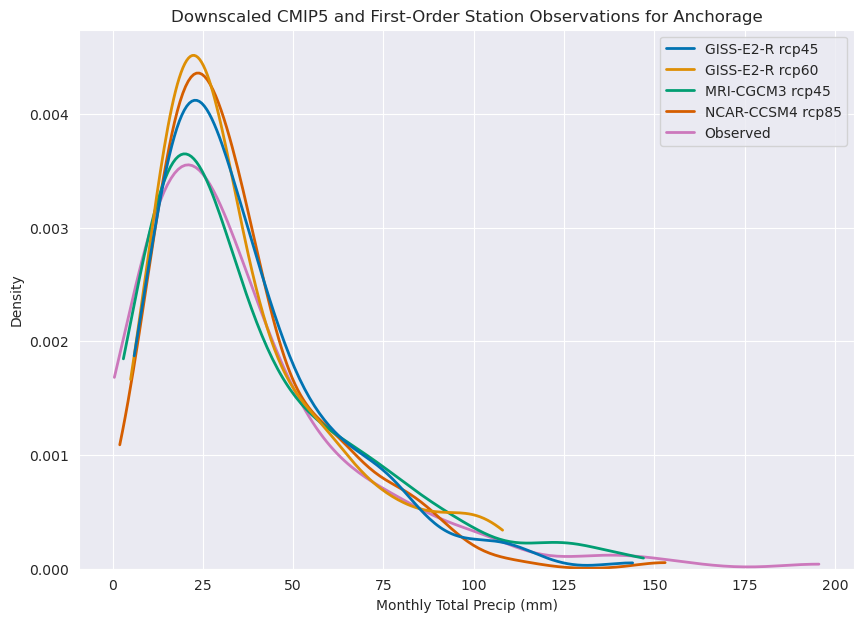

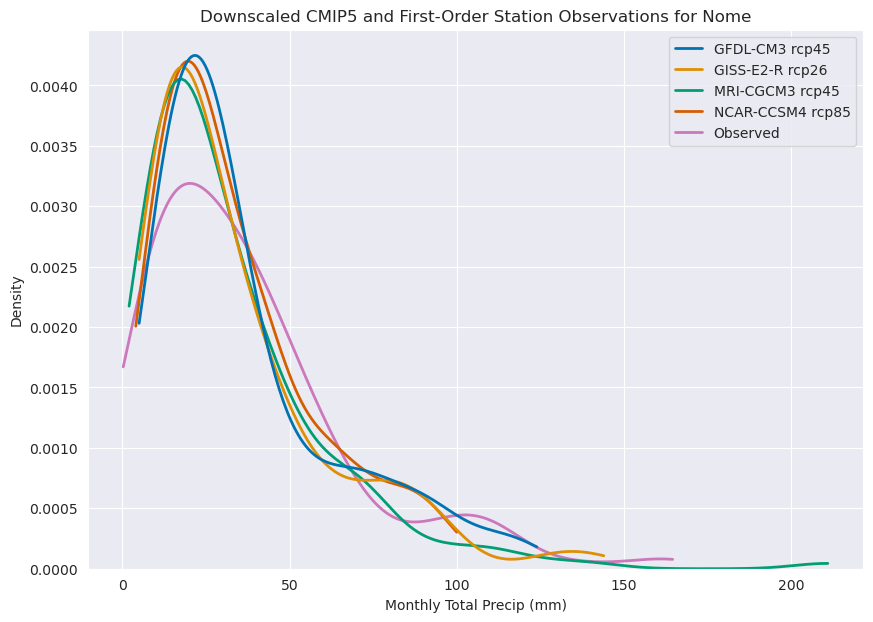

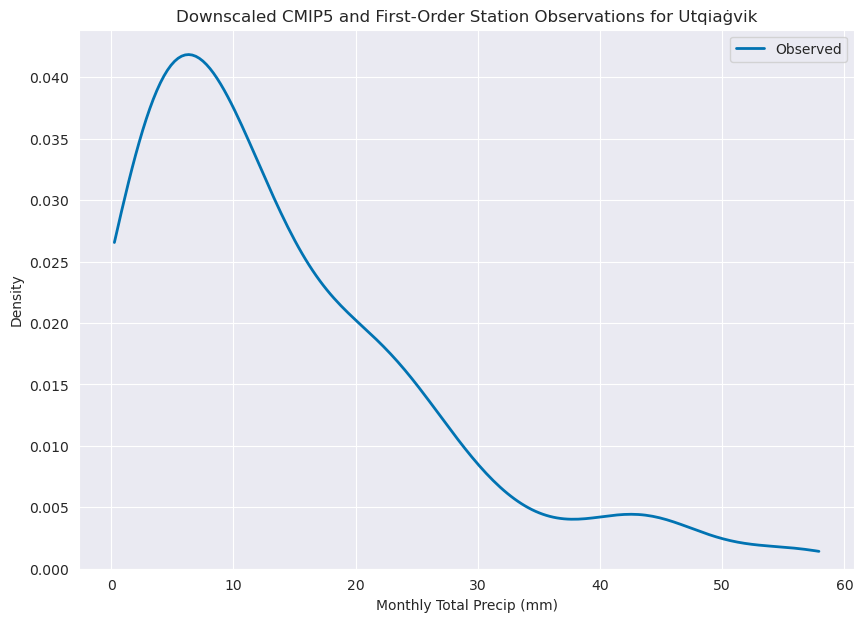

In [13]:
sns.set_style("darkgrid")
for k in di.keys():
    pr_perf_by_station = pr_perf[pr_perf.Station == k]
    pr_perf_by_var = pr_perf_by_station[pr_perf_by_station.Variable == "pr_total_mm"]
    pr_perf_by_var.set_index(["Model", "Scenario", "Variable"], inplace=True)

    pr_perf_model_data_df=pd.DataFrame()

    model_data = []
    for j in pr_perf_by_var.index.values:
        md = di[k]["extracted_data"].loc[(j)]
        pr_perf_model_data_df[f"{j[0]} {j[1]}"] = md
    pr_perf_model_data_df["Observed"] = di[k]["pr_total_mm"]
    
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    f = sns.kdeplot(pr_perf_model_data_df, palette="colorblind", linewidth=2, cut=0, ax=ax)
    f.set(xlabel = "Monthly Total Precip (mm)", title =f"Downscaled CMIP5 and First-Order Station Observations for {k}")
    
    figname = f"figs/{k.lower()}_pr_total_mm_fail_reject.png"
    # plt.show()
    plt.savefig(figname, bbox_inches="tight", dpi=144)

Look at how the Observed KDE has a shorter peak than the CMIP5 Data! This is true for Nome and Anchorage. The short peak means that reality has far more variance than the modeled data account for.

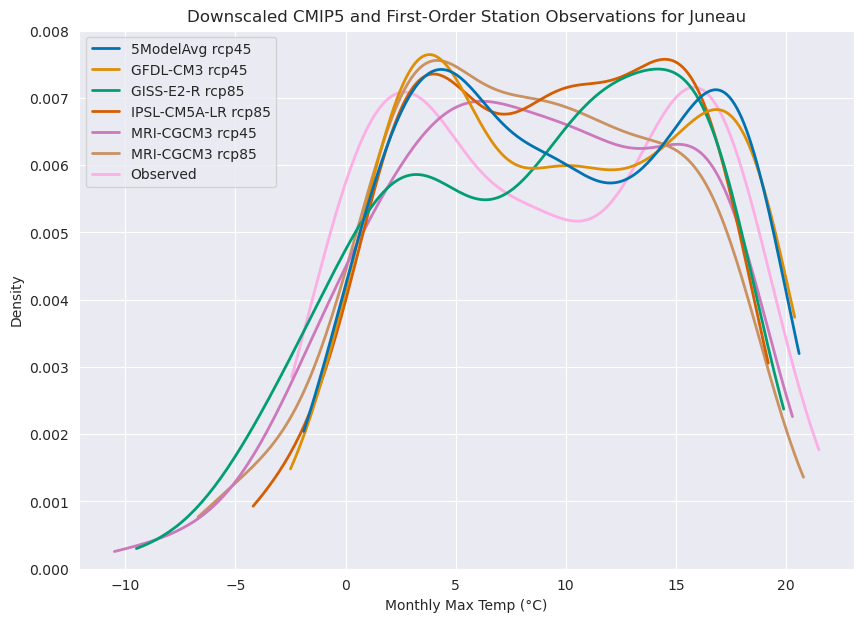

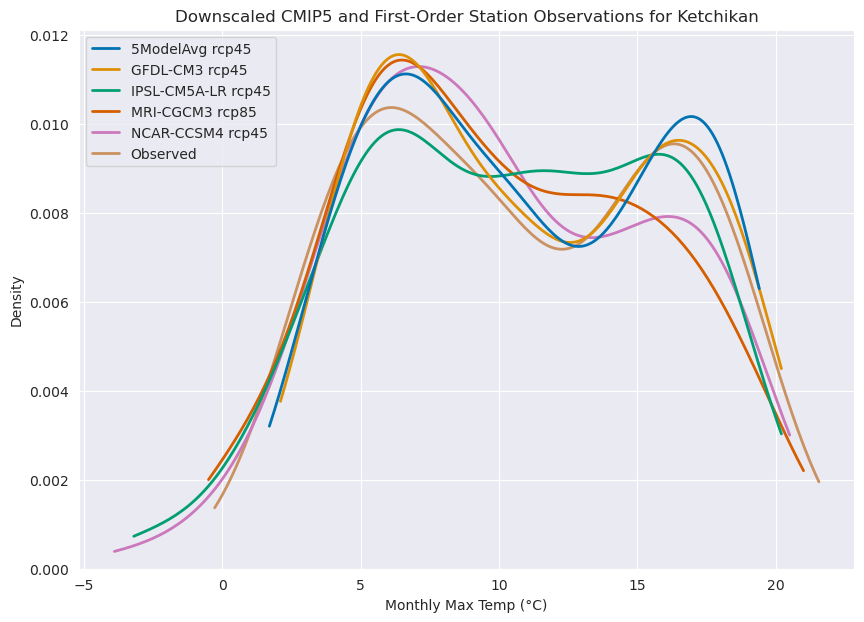

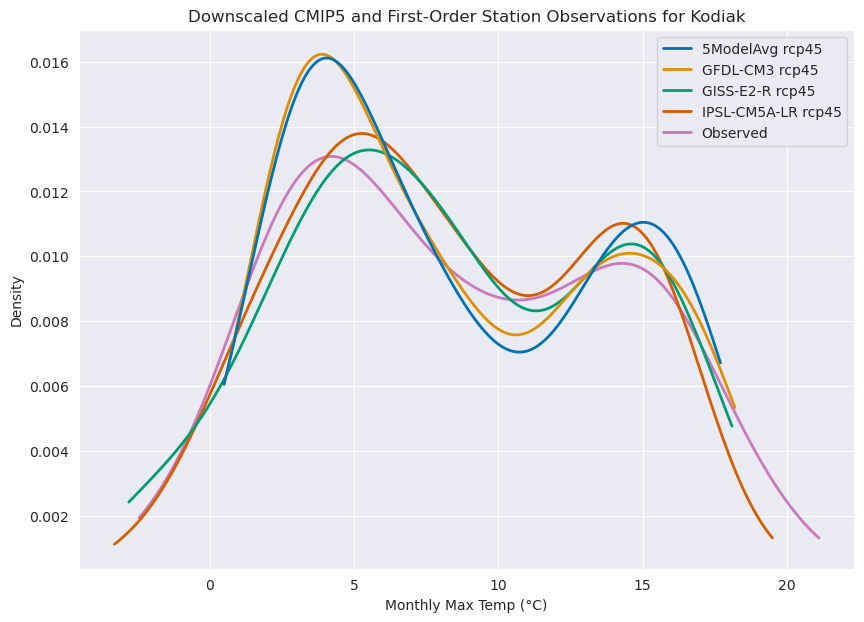

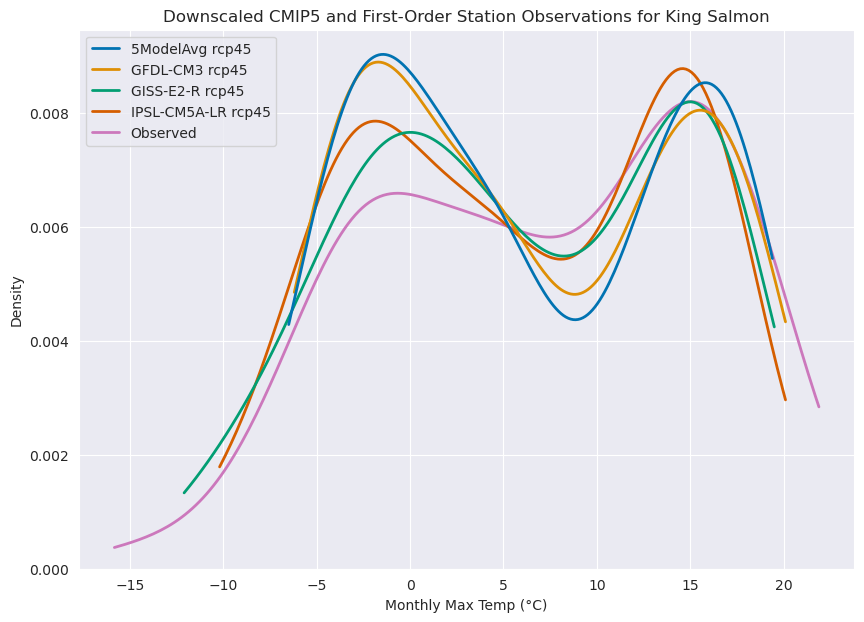

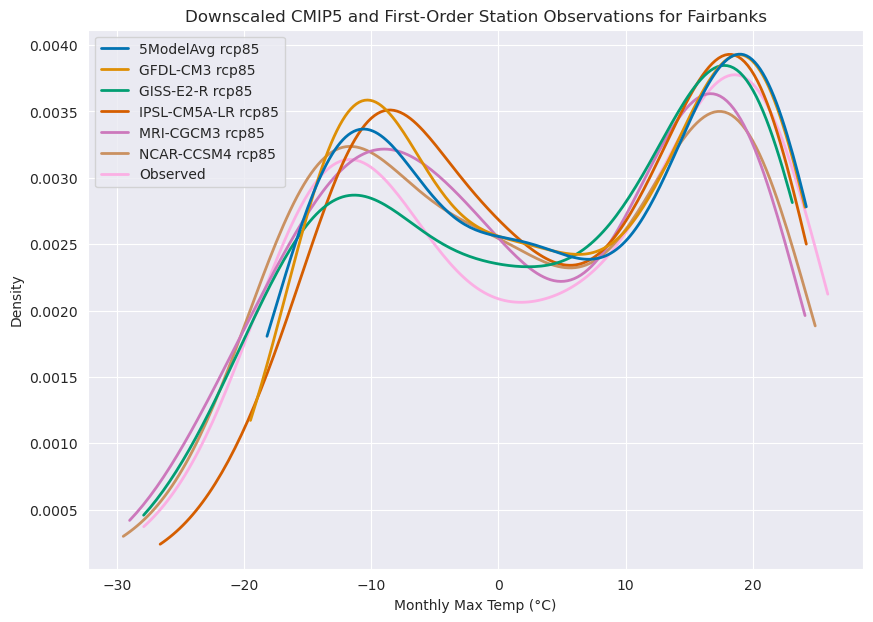

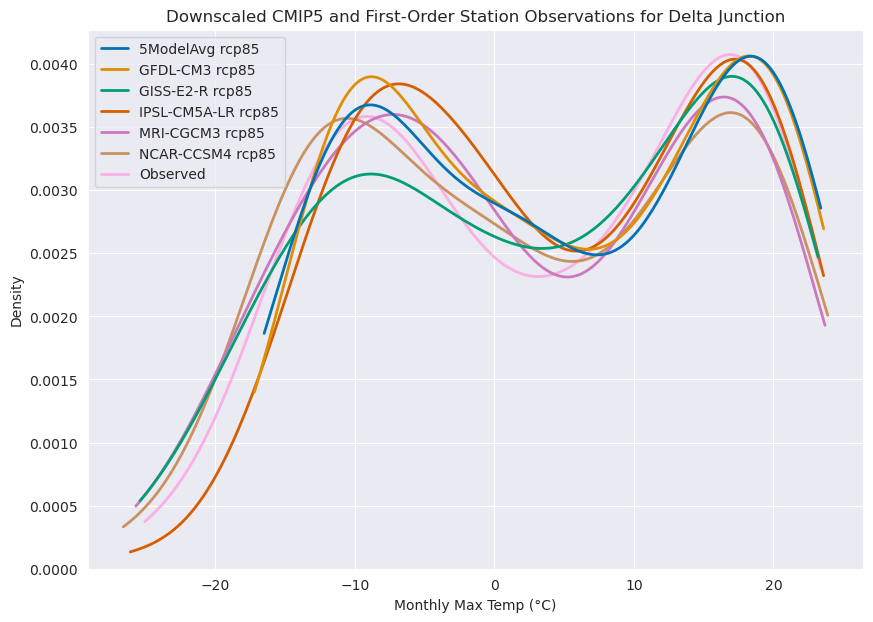

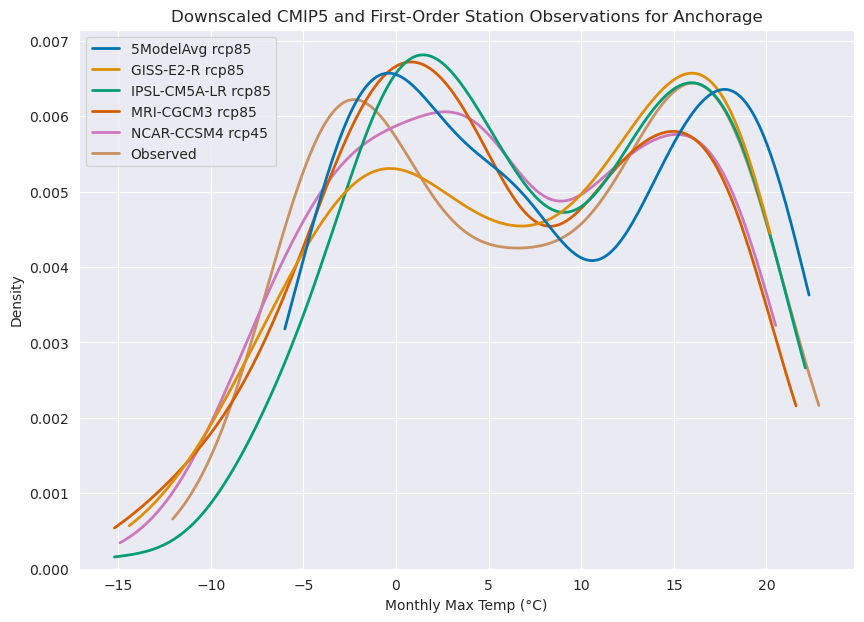

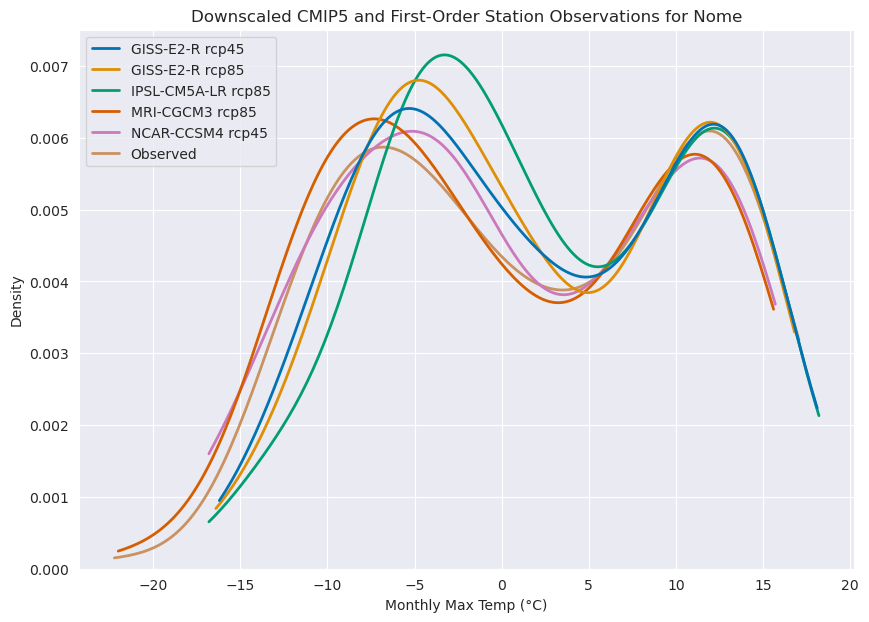

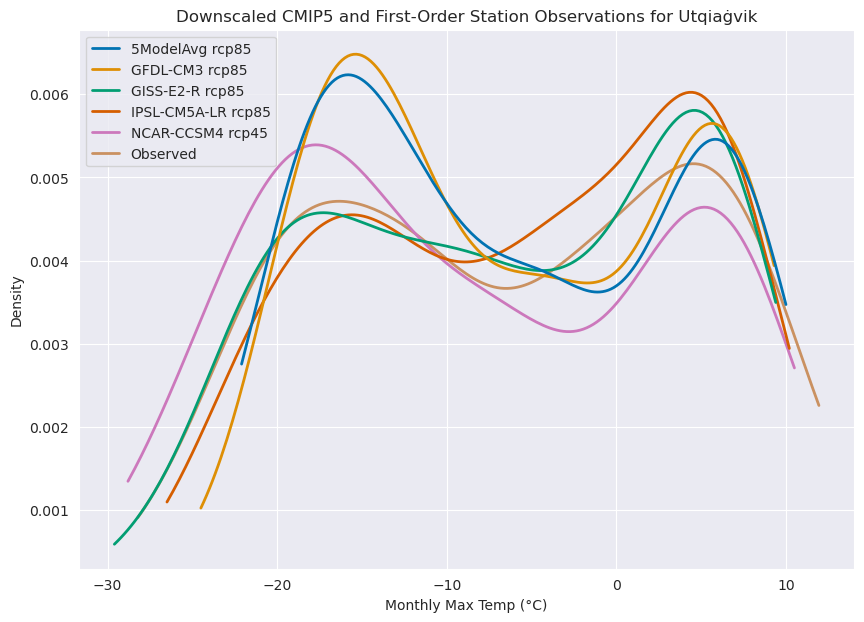

In [14]:
for k in di.keys():
    pr_perf_by_station = pr_perf[pr_perf.Station == k]
    pr_perf_by_var = pr_perf_by_station[pr_perf_by_station.Variable == "tasmax_mean_C"]
    pr_perf_by_var.set_index(["Model", "Scenario", "Variable"], inplace=True)

    pr_perf_model_data_df=pd.DataFrame()

    model_data = []
    for j in pr_perf_by_var.index.values:
        md = di[k]["extracted_data"].loc[(j)]
        pr_perf_model_data_df[f"{j[0]} {j[1]}"] = md
    pr_perf_model_data_df["Observed"] = di[k]["tasmax_mean_C"]
    
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    f = sns.kdeplot(pr_perf_model_data_df, palette="colorblind", linewidth=2, cut=0, ax=ax)
    f.set(xlabel = "Monthly Max Temp (°C)", title =f"Downscaled CMIP5 and First-Order Station Observations for {k}")
    
    figname = f"figs/{k.lower()}_tasmax_mean_C_fail_reject.png"
    #plt.show()
    plt.savefig(figname, bbox_inches="tight", dpi=144)

Look at Utgiavik. Nearly all the first bump peaks for the CMIP data are right shifted. 

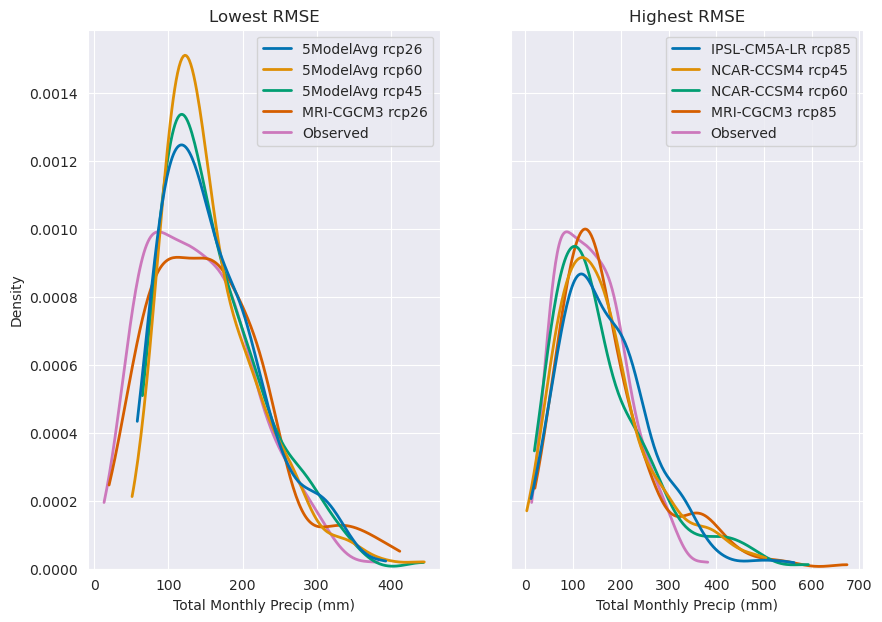

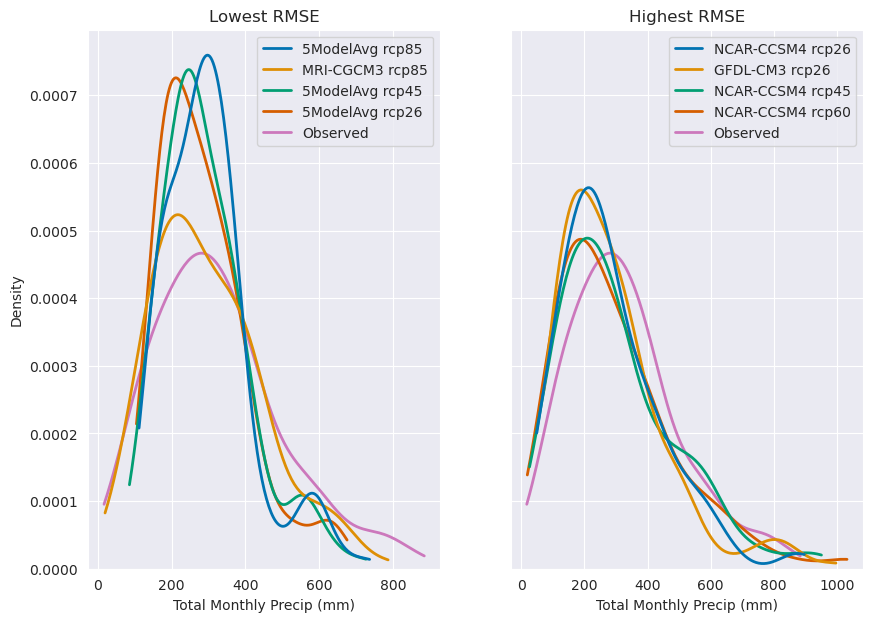

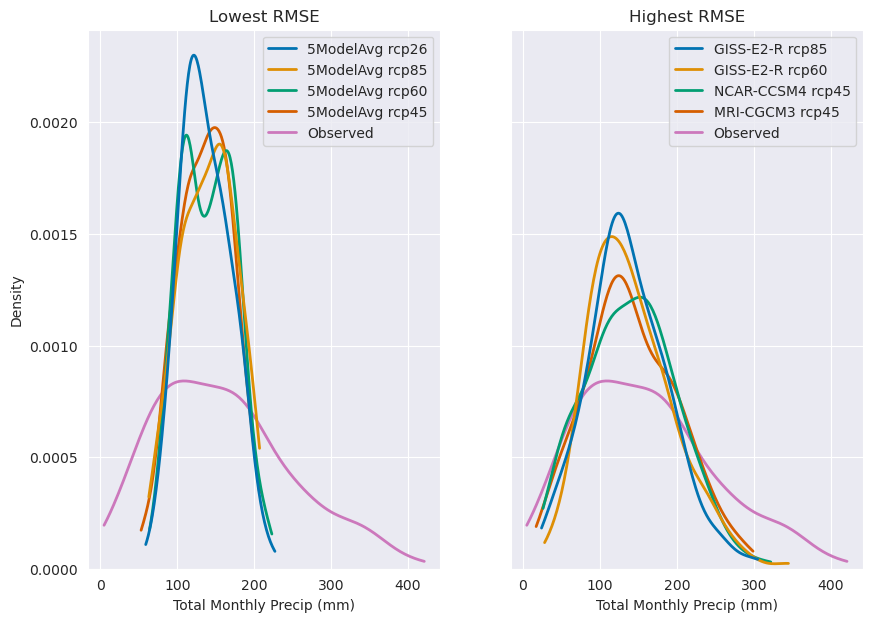

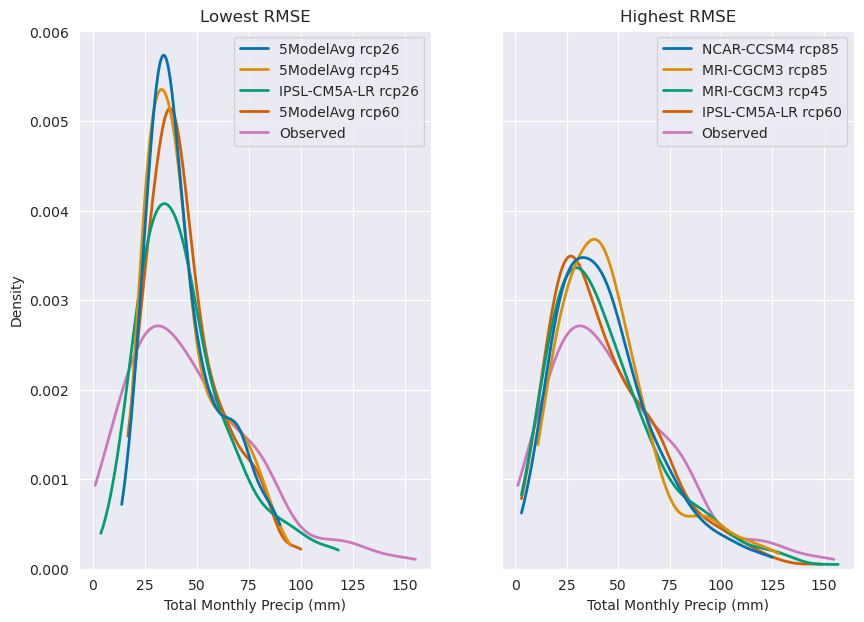

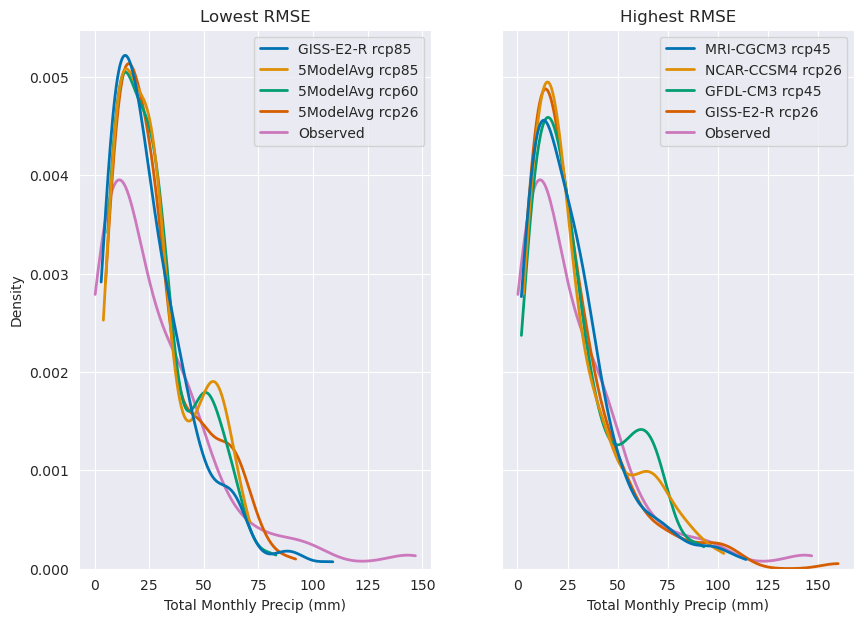

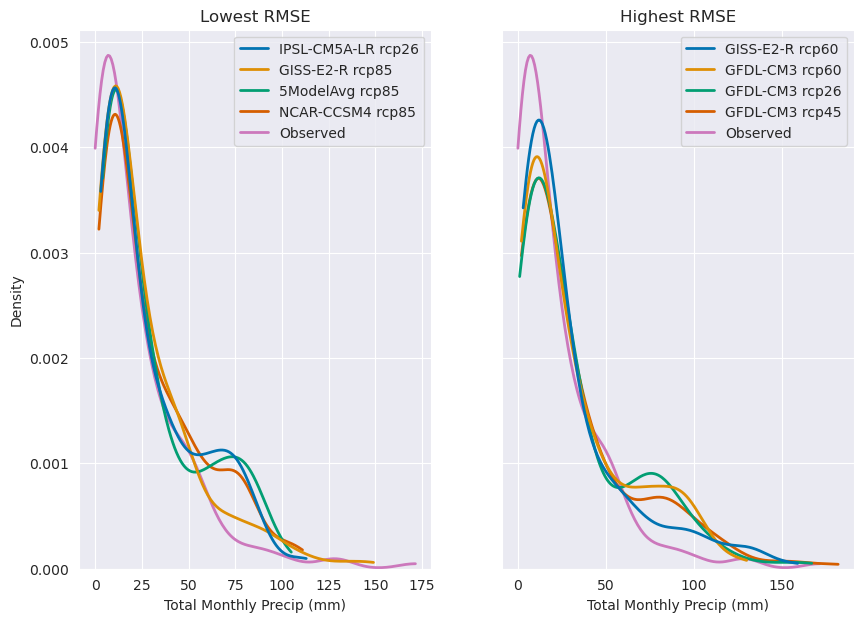

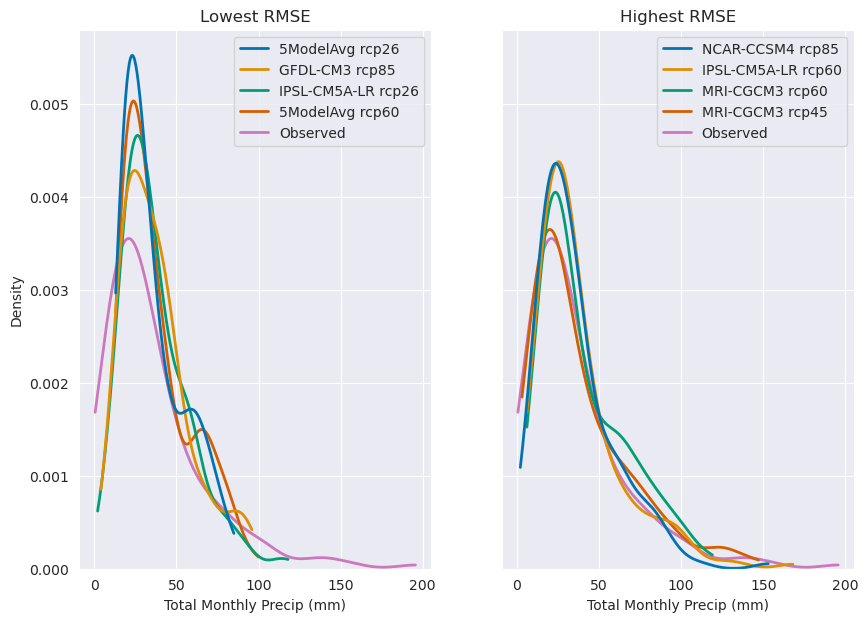

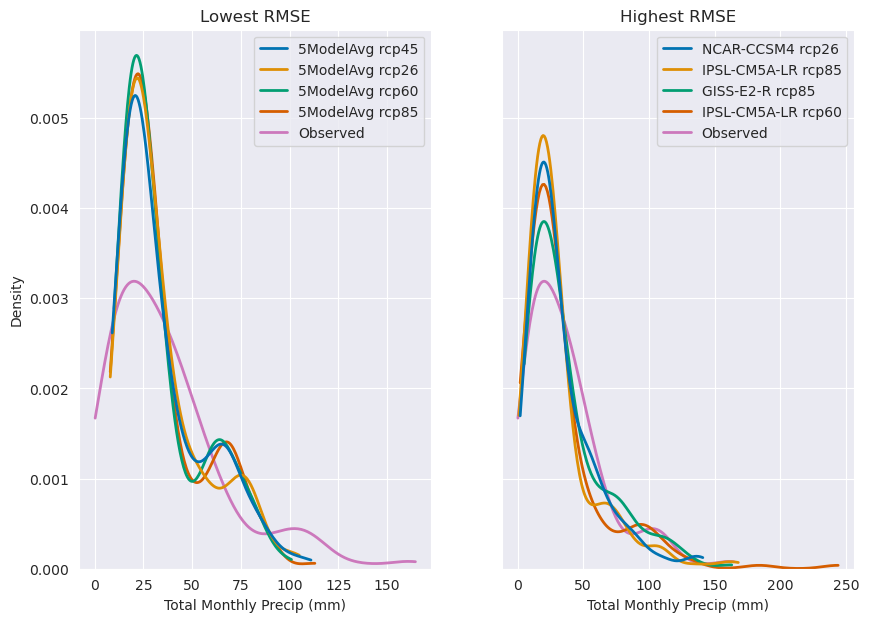

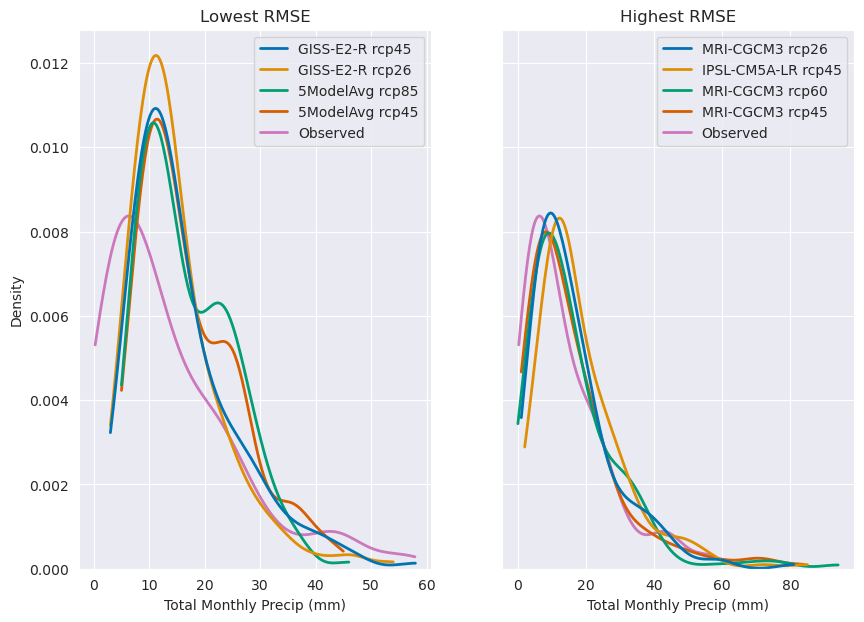

In [17]:
for k in di.keys():

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 7))

    station_rmse_pct = statdf[statdf.Station == k].copy()
    
    station_rmse_pct_by_var = station_rmse_pct[station_rmse_pct.Variable == "pr_total_mm"].copy()
    
    station_rmse_pct_by_var['RMSE percentile'] = station_rmse_pct_by_var["RMSE"].rank(pct=True).round(2)*100
    best_4_rmse = station_rmse_pct_by_var.sort_values("RMSE percentile").iloc[0:4]
    worst_4_rmse = station_rmse_pct_by_var.sort_values("RMSE percentile").iloc[-4:]
    
    for pct_rmse, ax, t in zip([best_4_rmse, worst_4_rmse], axes, ["Lowest RMSE", "Highest RMSE"]):
        pct_rmse.set_index(["Model", "Scenario", "Variable"], inplace=True)
        pct_rmse_data_df = pd.DataFrame()

        for j in pct_rmse.index.values:
            md = di[k]["extracted_data"].loc[(j)]
            pct_rmse_data_df[f"{j[0]} {j[1]}"] = md
        pct_rmse_data_df["Observed"] = di[k]["pr_total_mm"]
    
        sns.kdeplot(pct_rmse_data_df, palette="colorblind", linewidth=2, cut=0, ax=ax)
        ax.set(xlabel="Total Monthly Precip (mm)", title=t)

In [ ]:
for k in di.keys():

    station_nrmse_pct = statdf[statdf.Station == k].copy()
    for var in clim_vars:
        
        fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 7))
        
        station_nrmse_pct_by_var = station_nrmse_pct[station_nrmse_pct.Variable == var].copy()
        station_nrmse_pct_by_var['NRMSE percentile'] = station_nrmse_pct_by_var["NRMSE"].rank(pct=True).round(2)*100
        best_5_nrmse = station_nrmse_pct_by_var.sort_values("NRMSE percentile").iloc[0:4]
        worst_5_nrmse = station_nrmse_pct_by_var.sort_values("NRMSE percentile").iloc[-4:]
        
        for pct_nrmse, ax, t in zip([best_5_nrmse, worst_5_nrmse], axes, ["Best NRMSE", "Worst NRMSE"]):
            pct_nrmse.set_index(["Model", "Scenario", "Variable"], inplace=True)
            pct_nrmse_data_df = pd.DataFrame()
            
            
            model_data = []
            for j in pct_nrmse.index.values:
                md = di[k]["extracted_data"].loc[(j)]
                pct_nrmse_data_df[f"{j[0]} {j[1]}"] = md
                
            pct_nrmse_data_df["Observed"] = di[k][var]
        
        
            sns.kdeplot(pct_nrmse_data_df, palette="colorblind", linewidth=2, cut=0, ax=ax)
            ax.set(xlabel=var, title=t)
            
            del pct_nrmse_data_df["Observed"]

        plt.suptitle(f"{k} {var}")
        figname = f"figs/{k.lower()}_{var}_nrmse_ranks.png"
        plt.show()
        #plt.savefig(figname, bbox_inches="tight", dpi=144)
        
## make sure the dict is correct and being built from a fresh state with no duplicate keys.


Look how frequently the best performing projection w.r.t to NRMSE is the 5-model blend. This is because the observed data has a broader peak, and the averaging condenses the model data into that peak. 

In [ ]:


## are any of the top or bottom 10% NRMSE models also in our top test stat performers?

## Look at absolute accuracy
## NRMSE for everything
## NRMSE by variable
## NRMSE by location



In [ ]:
# how do the top 5 models perform when we shift one grid cell?

The conclusion is that while at least some selection of the models performs excellent with respsect to (STD ERRORS between x and x percent) theere is geographic variability, and the majority of CMIP5 conditions fail to account for the variability in the observed datasets. 

In [ ]:
statdf.groupby(["Station"])["NRMSE"].apply("mean").round(2).sort_values()

In [ ]:
pr_perf.groupby(["Model"])["NRMSE"].apply("mean").round(2).sort_values()

In [ ]:
pr_perf.groupby(["Scenario"])["NRMSE"].apply("mean").round(2).sort_values()

In [ ]:
tasmax_perf.groupby(["Model"])["NRMSE"].apply("mean").round(2).sort_values()

3x3 Table with each station having the top performing models in a table
Do any models perform well for temp and precip?